In [1]:
%%capture
%load_ext autoreload
%autoreload 2
from setup_nb_env import *
DATA_DIR = '/work/users/k/4/k4thryn/Repos/OLD_EpSampling_Nov2024/data/'

from epsampling.modeling import *

### <font color=blue> Poisson-based General Linear Model
- Poisson regression is often used for count or rate prediction. However, if the predictions are based in different contexts (e.g. timeframes, populations) then an offset is required to bring all predictions into the same prediction space. That is what we are doing here. 
    
    <font color=blue>
    
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; <font color=blue> $ log( \mathbb{E}(y)) = b_0 + b_1 x + log(t) $
    </font>
    <br>
    
    

    

    

# <font color=blue> 1) Dataset

In [2]:
ts = '20241108-123515'
DATA_DIR = '/work/users/k/4/k4thryn/Repos/OLD_EpSampling_Nov2024/data/'

fpath = os.path.join(DATA_DIR,'processed',f'training_target_df_{ts}.csv')
dff = pd.read_csv(fpath)

pd.set_option('display.max_columns', None)

d = {'Proj_state_inc_deaths':'PROJ state deaths',
     'True_county_inc_deaths':'TRUE county deaths',
     'Pop':'County population',
     'Naive_proj_deaths':'Naive PROJ deaths',
    }

dff.rename(d,axis=1,inplace=True)

Y_COL = 'TRUE county deaths'
X_COLS = ['PROJ state deaths','County population']
NAIVE_COL = 'Naive PROJ deaths'

dff.dropna(inplace=True)
df = dff[dff[Y_COL] >= 0]

In [3]:
df = get_model_df(df, X_COLS, Y_COL, NAIVE_COL)
display(df)

,Date,Fips,PROJ state deaths,County population,TRUE county deaths,Naive PROJ deaths
11,20200905,37001,157.0,169185,0.0,2.562167
12,20200912,37001,176.0,169185,2.0,2.872239
13,20200919,37001,157.0,169185,0.0,2.562167
14,20200926,37001,171.0,169185,6.0,2.790641
15,20201003,37001,171.0,169185,2.0,2.790641
...,...,...,...,...,...,...
9895,20220409,37199,55.0,18357,0.0,0.097389
9896,20220416,37199,41.0,18357,0.0,0.072599
9897,20220423,37199,60.0,18357,0.0,0.106243
9898,20220430,37199,33.0,18357,0.0,0.058433


In [10]:
# df[Y_COL] = df[Y_COL].apply(lambda x: np.log(x+1))
# df[NAIVE_COL] = df[NAIVE_COL].apply(lambda x: np.log(x+1))
# display(df)

## <font color=blue> 2) Training: County population + Predicted state deaths

    
<font color=blue> _Compare regression algorithms:_
1. <font color=blue>  Linear 
1. <font color=blue>  Poisson 
1. <font color=blue>  Zero-inflated
    
This is our most simplistic model. We are predicting the number of county deaths given two covariates: 1) projected state deaths (from COVIDHub) and 2) county population. We will consider vanilla linear regression, poisson regression, and zero-inflated regression.

### <font color=blue> Model design
- <font color=blue> **_Train-test split:_** Our training and test/evaluation set will be partitioned based on (2 month)-wise chunks. That is, we will evaluate our model on temporally consecutive targets over the course of 8 weeks, and we will train on the remaining weeks.
    - <font color=black> **Train samps:** 7939
    - <font color=black> **Test samps:** 771
- <font color=blue> **_Cross validation protocol:_** We will train a model for each month, for a total of 10 models. From these, we can evaluate average performance for each regression algorithm.
    

In [5]:
res_dfs = []
models = {}
chunks = get_chunks(list(df.Date.unique()), num_membs=8)

for ALG in ['Linear','Poisson']:
#     ,'Zero-Inflated']:
# for ALG in ['Poisson']:
    for i,test_chunk in tqdm(enumerate(chunks), total=len(chunks)):

        df_train, df_test = get_date_chunked_splits(df, chunks, i)
        
        # # # # # # # # # # # # # # # #
        df_test = df_train.copy()
        # # # # # # # # # # # # # # # #
        
        df_test[f'Run'] = i
        
        PRED_COL = 'PRED county deaths'    
        df_res = get_df_res(df_train, df_test, X_COLS, Y_COL, PRED_COL, ALG, standardize=False)

#         if i==0: display(df_test.head(), df_res.head())

        res_dfs.append(df_res)
    
df_full_res = pd.concat(res_dfs)
with pd.option_context('display.precision', 3):
    display(df_full_res)

100%|██████████| 11/11 [00:00<00:00, 73.76it/s]


,Date,Fips,PROJ state deaths,County population,TRUE county deaths,Naive PROJ deaths,Run,Algorithm,PRED county deaths
19,20201031,37001,198.0,169185,16.0,3.231,0,Linear,3.131e+00
20,20201107,37001,221.0,169185,5.0,3.607,0,Linear,3.328e+00
21,20201114,37001,223.0,169185,3.0,3.639,0,Linear,3.345e+00
22,20201121,37001,200.0,169185,0.0,3.264,0,Linear,3.149e+00
23,20201128,37001,257.0,169185,1.0,4.194,0,Linear,3.636e+00
...,...,...,...,...,...,...,...,...,...
9888,20220219,37199,561.0,18357,1.0,0.993,10,Poisson,9.767e+146
9889,20220226,37199,476.0,18357,0.0,0.843,10,Poisson,5.262e+124
9890,20220305,37199,332.0,18357,1.0,0.588,10,Poisson,9.899e+86
9891,20220312,37199,233.0,18357,0.0,0.413,10,Poisson,1.146e+61


## <font color=blue> 3) Evaluation

## <font color=blue> a. _Metrics_ 
Average across cross-validation splits.

In [6]:
metric_sers = []

for alg in df_full_res.Algorithm.unique():
    for run in df_full_res.Run.unique():
        subdf = df_full_res[(df_full_res['Run']==run) & (df_full_res['Algorithm']==alg)]
        ser = get_metrics_ser(subdf, 
                              target_col=Y_COL,
                              pred_col=PRED_COL,
                              alg_col=alg,
                              naive_col=NAIVE_COL)

        metric_sers.append(ser)
    
df_run = pd.DataFrame(metric_sers)

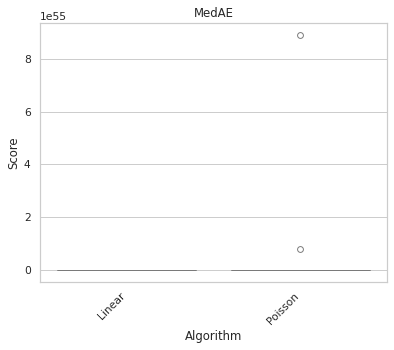

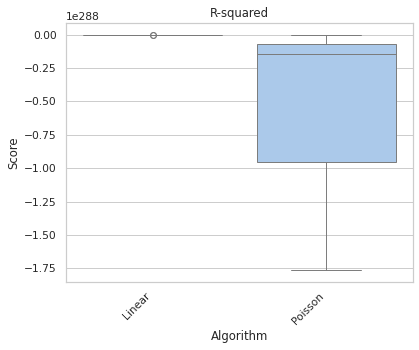

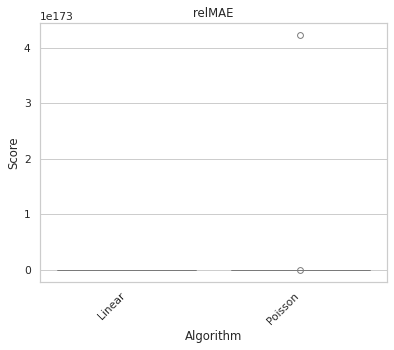


* MedAE *
== Linear ==
 Mean: 1.296
 Median: 1.304
== Poisson ==
 Mean: 8.833304775411274e+54
 Median: 2.4366807178622335e+46

* R-squared *
== Linear ==
 Mean: 0.29
 Median: 0.288
== Poisson ==
 Mean: -inf
 Median: -inf

* relMAE *
== Linear ==
 Mean: 1.101
 Median: 1.102
== Poisson ==
 Mean: 3.855377669365112e+172
 Median: 7.90013260815804e+160


In [7]:
df_melt = pd.melt(df_run, id_vars=['Algorithm'], 
                  value_vars=['MAE', 'MedAE', 'R-squared','MSE','relMAE'], 
                  var_name='Metric', value_name='Score')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1, style='whitegrid', palette='pastel') 
DPI = 70

for metric in  ['MedAE', 'R-squared', 'relMAE']:
    df_plot = df_melt[df_melt.Metric==metric]
    sns.boxplot(df_plot, x='Algorithm',y='Score')   
    plt.title(f'{metric}')
    plt.xticks(rotation=45,ha='right')
    plt.gcf().set_dpi(DPI)
    plt.show()

for metric in  ['MedAE', 'R-squared', 'relMAE']:
    print(f'\n* {metric} *')
    for alg in df_full_res.Algorithm.unique():
        dff_melt = df_melt[(df_melt['Metric']==metric) & (df_melt['Algorithm']==alg)]
        print(f'== {alg} ==')
        print(f' Mean: {round(dff_melt.Score.mean(),3)}\n Median: {round(dff_melt.Score.median(),3)}')

## <font color=blue> b. _Plots_

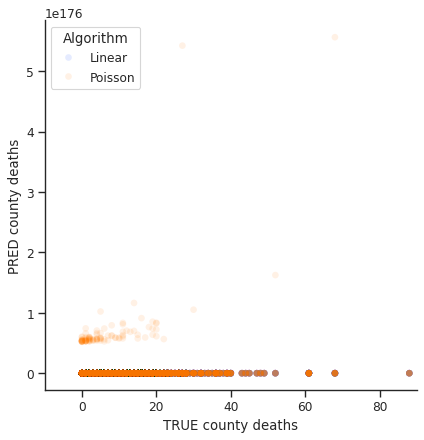

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1, style='ticks', palette='bright') 

figsize = (8,6)
alpha = 0.1
sizes = 2
linewidth = 0

DPI = 80
FIGSIZE = (6,6)

# df = df_pred

plt.figure(figsize=FIGSIZE)

sns.scatterplot(data=df_full_res, x=Y_COL, y=PRED_COL, alpha=alpha, sizes=sizes, linewidth=linewidth, hue='Algorithm')
# sns.scatterplot(data=df_full_res, x=Y_COL, y=PRED_COL, alpha=alpha, sizes=sizes, linewidth=linewidth)
# sns.scatterplot(data=df_full_res, x=Y_COL, y=PRED_COL, alpha=alpha, sizes=sizes, linewidth=linewidth)

sns.despine()
plt.xlim((-10, 90))
plt.gcf().set_dpi(DPI)
plt.show()


# figsize = (8,6)
# alpha = 0.15
# sizes = 2
# linewidth = 0

# sns.regplot(data=df_full_res,  x=Y_COL, y=PRED_COL,
#             scatter_kws={'s':10, 'alpha':0.5}, line_kws={'color':'k','linewidth':1})
# sns.despine()
# plt.title('raw') 
# plt.title('y+(1)/pop*100000\n r2: 0.934336') 
# plt.title('y/pop*100000\n r2: -0.016382') 

# plt.show()

In [9]:
allDone()